### Imports

In [1]:
from qilisdk.speqtrum import SpeQtrum

import os
from collections import Counter
import matplotlib.pyplot as plt

from qilisdk.backends import QutipBackend
from qilisdk.digital import Circuit, H, CNOT, M, X
from qilisdk.functionals import Sampling

In [2]:
client = None
backend = QutipBackend()

We will use 5 qubits:

0,1,2,3 will encode the position in the graph as a binary number (e.g. |0000> is position 0, |0101> is position 5, |1111> is position 15)

4 will be the coin qubit

In [165]:
def multi_controlled_x_to_cnots(circuit, controls, target, ancilla_start=None):
    """
    Convert a multi-controlled X gate to a sequence of CNOT gates
    
    Args:
        controls: List of control qubit indices
        target: Target qubit index
        ancilla_start: Starting index for ancilla qubits (if None, auto-assign)
    
    Returns:
        Circuit object with CNOT sequence
    """
    
    if len(controls) == 0:
        # No controls - just return empty circuit (X gate is not CNOT)
        return circuit
    
    elif len(controls) == 1:
        # Single control - just one CNOT
        circuit.add(CNOT(controls[0], target))
        return circuit
    
    elif len(controls) == 2:
        # Toffoli gate - standard decomposition using 1 ancilla
        if ancilla_start is None:
            ancilla = max(controls + [target]) + 1
        else:
            ancilla = ancilla_start
        
        # Toffoli decomposition using ancilla
        circuit.add(CNOT(controls[0], ancilla))
        circuit.add(CNOT(controls[1], target))
        circuit.add(CNOT(ancilla, target))
        circuit.add(CNOT(controls[1], target))
        circuit.add(CNOT(controls[0], ancilla))
        return circuit
    
    else:
        # Multiple controls - recursive decomposition
        return _multi_controlled_x_recursive(circuit, controls, target, ancilla_start)

def _multi_controlled_x_recursive(circuit, controls, target, ancilla_start):
    """Recursive helper for multi-controlled X decomposition"""
    if len(controls) == 2:
        # Base case - use Toffoli decomposition
        if ancilla_start is None:
            ancilla = max(controls + [target]) + 1
        else:
            ancilla = ancilla_start
        
        circuit.add(CNOT(controls[0], ancilla))
        circuit.add(CNOT(controls[1], target))
        circuit.add(CNOT(ancilla, target))
        circuit.add(CNOT(controls[1], target))
        circuit.add(CNOT(controls[0], ancilla))
        return circuit
    
    else:
        # Recursive case - break down into smaller controlled operations
        if ancilla_start is None:
            ancilla = max(controls + [target]) + 1
        else:
            ancilla = ancilla_start
        
        # Decompose into two smaller multi-controlled operations
        first_controls = controls[:-1]  # All but last control
        last_control = controls[-1]     # Last control
        
        # First: multi-controlled X on ancilla (with n-1 controls)
        _multi_controlled_x_recursive(circuit, first_controls, ancilla, ancilla_start + 1 if ancilla_start else None)
        
        # Second: controlled-X on target (control=ancilla, target=target)
        circuit.add(CNOT(ancilla, target))
        
        # Third: undo the first operation
        _multi_controlled_x_recursive(circuit, first_controls, ancilla, ancilla_start + 1 if ancilla_start else None)
        
        # Fourth: controlled-X on target (control=last_control, target=target)  
        circuit.add(CNOT(last_control, target))
        
        return circuit

def multi_controlled_x_to_cnots_simple(circuit, controls, target):
    """
    Simplified version that uses a fixed number of ancilla qubits
    and provides a cleaner decomposition for common cases
    """
    n_controls = len(controls)
    
    if n_controls == 0:
        return circuit
    
    elif n_controls == 1:
        circuit.add(CNOT(controls[0], target))
    
    elif n_controls == 2:
        # Toffoli with 1 ancilla
        ancilla = max(controls + [target]) + 1
        circuit.add(CNOT(controls[0], ancilla))
        circuit.add(CNOT(controls[1], target))
        circuit.add(CNOT(ancilla, target))
        circuit.add(CNOT(controls[1], target))
        circuit.add(CNOT(controls[0], ancilla))
    
    elif n_controls == 3:
        # 3-controlled X with 1 ancilla
        ancilla = max(controls + [target]) + 1
        # Decompose into two Toffoli gates
        circuit.add(CNOT(controls[0], ancilla))
        circuit.add(CNOT(controls[1], target))
        circuit.add(CNOT(ancilla, target))
        circuit.add(CNOT(controls[1], target))
        circuit.add(CNOT(controls[0], ancilla))
        
        # Second Toffoli with the third control
        circuit.add(CNOT(controls[2], target))
    
    else:
        # For more controls, use the recursive method
        ancilla_start = max(controls + [target]) + 1
        return _multi_controlled_x_recursive(circuit, controls, target, ancilla_start)
    
    return circuit

In [ ]:
def get_ancilla(self):
    """Get an available ancilla qubit"""
    if self.ancilla_used >= self.n_ancilla:
        raise ValueError("No more ancilla qubits available")
    ancilla = self.ancilla_pool[self.ancilla_used]
    self.ancilla_used += 1
    return ancilla

def release_ancilla(self, ancilla):
    """Release an ancilla qubit (simplified management)"""
    # In practice, you'd want more sophisticated ancilla management
    pass


def decompose_multi_controlled_x(circuit, controls, target):
    """
    Decompose multi-controlled X gate into CNOTs using ancilla qubits
    """
    n_controls = len(controls)
    
    if n_controls == 0:
        circuit.add(X(target))
    
    elif n_controls == 1:
        circuit.add(CNOT(controls[0], target))
    
    elif n_controls == 2:
        # Toffoli gate decomposition with 1 ancilla
        ancilla = circuit.get_ancilla()
        circuit.add(CNOT(controls[0], ancilla))
        circuit.add(CNOT(controls[1], target))
        circuit.add(CNOT(ancilla, target))
        circuit.add(CNOT(controls[1], target))
        circuit.add(CNOT(controls[0], ancilla))
        circuit.release_ancilla(ancilla)
    
    else:
        # For 3+ controls, use recursive decomposition
        _decompose_mcx_recursive(circuit, controls, target)

def _decompose_mcx_recursive(circuit, controls, target):
    """Recursive decomposition for multi-controlled X"""
    n_controls = len(controls)
    
    if n_controls == 2:
        # Base case - Toffoli
        ancilla = circuit.get_ancilla()
        circuit.add(CNOT(controls[0], ancilla))
        circuit.add(CNOT(controls[1], target))
        circuit.add(CNOT(ancilla, target))
        circuit.add(CNOT(controls[1], target))
        circuit.add(CNOT(controls[0], ancilla))
        circuit.release_ancilla(ancilla)
        return
    
    elif n_controls == 1:
        circuit.add(CNOT(controls[0], target))
        return
    
    # Recursive case: break into smaller multi-controlled operations
    first_half = controls[:n_controls//2]
    second_half = controls[n_controls//2:]
    
    ancilla1 = circuit.get_ancilla()
    
    # First multi-controlled X on ancilla
    _decompose_mcx_recursive(circuit, first_half, ancilla1)
    
    # Second multi-controlled X on target (controlled by ancilla + second half)
    _decompose_mcx_recursive(circuit, [ancilla1] + second_half, target)
    
    # Undo first operation
    _decompose_mcx_recursive(circuit, first_half, ancilla1)
    
    # Final multi-controlled X on target (controlled by second half)
    _decompose_mcx_recursive(circuit, second_half, target)
    
    circuit.release_ancilla(ancilla1)

def calculate_max_ancilla_needed(n_qubits):
    """Calculate maximum ancilla needed for the worst-case multi-controlled gate"""
    # The worst case is when we control on all qubits except the target
    max_controls = n_qubits - 1
    # For linear decomposition, we need n_controls - 2 ancilla
    return max(0, max_controls - 2)

### Definition of important functions

Here we define the addition and subtraction gates

In [3]:
def apply_addition(circuit, n_qubits, active):

    for q in range(n_qubits, 0, -1):
        controls = [active[i] for i in range(n_qubits, q - 1, -1)]

        #decompose_multi_controlled_x(circuit, controls, active[q-1])
        circuit.add(X(qubit = active[q-1]).controlled(*controls))

        if q > 1:
            circuit.add(X(active[q-1]))

def apply_subtraction(circuit, n_qubits, active):
    for q in range(1, n_qubits + 1):
        controls = [active[i] for i in range(n_qubits, q - 1, -1)]

        #decompose_multi_controlled_x(circuit, controls, active[q-1])
        circuit.add(X(qubit = active[q-1]).controlled(*controls))

        if q < n_qubits:
            circuit.add(X(active[q]))


### Step function

Contiains the circuit to perform a step of the walker

In [4]:
def walk_step(circuit, n_qubits, active, coin):

    # Create superposition in coin qubit
    circuit.add(H(coin))
    circuit.add(X(coin))
    apply_addition(circuit, n_qubits, active)
    circuit.add(X(coin))
    apply_subtraction(circuit, n_qubits, active)




### Walking algorithm

Contains an initialization step and a loop over however many steps we choose

In [5]:
def quantum_walk(circuit, N_qubits, ACTIVE, coin, n_steps):
    #Initial state of graph register
    circuit.add(X(ACTIVE[0]))
    #Initial state of coin corresponding to $|down>$ state
    circuit.add(X(coin)) 

    for _ in range(n_steps):
        walk_step(circuit, N_qubits, ACTIVE, coin)

    register = ACTIVE[0:N_qubits+1] + [coin]

    circuit.add(M(*register))
    



In [6]:
N_REG  = 7
ACTIVE = [0, 1, 2, 3, 4, 5, 6]
SHOTS  = 100


circuit = Circuit(N_REG)

coin = ACTIVE[-1]
len_ancilla = len(ACTIVE)//2 -1 
len_walk_register = len(ACTIVE)//2

n_steps = 1


quantum_walk(circuit, N_REG-1, ACTIVE, coin, n_steps)



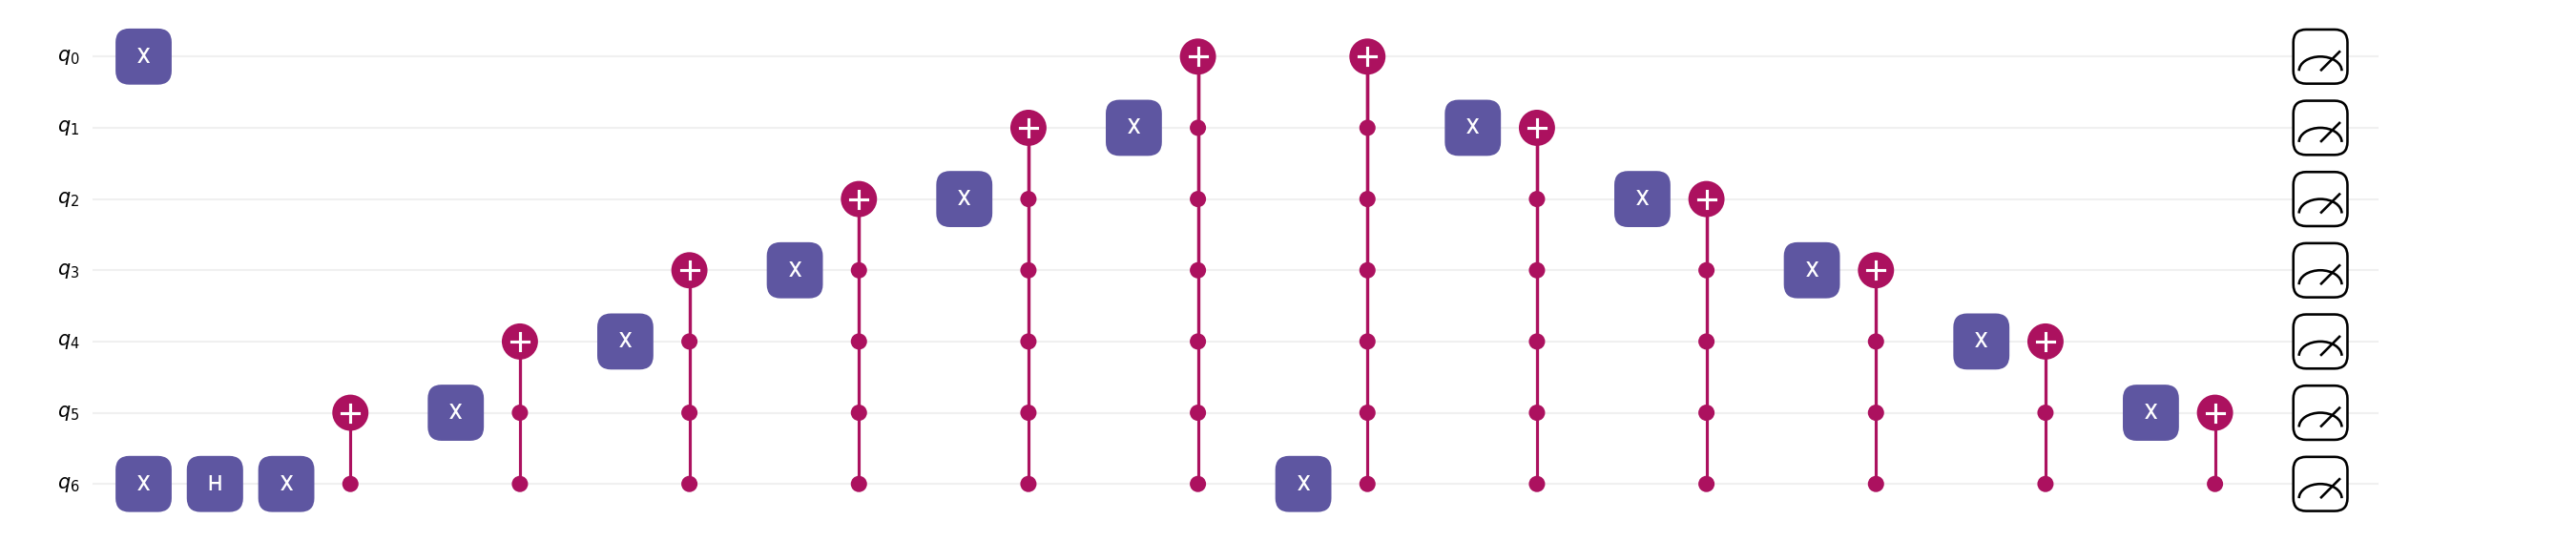

In [7]:
circuit.draw()

# VERSION WITH ANCILLA

In [8]:
def apply_addition(circuit, n_qubits, active):

    for q in range(n_qubits, 0, -1):
        controls = [active[i] for i in range(n_qubits, q - 1, -1)]

        #decompose_multi_controlled_x(circuit, controls, active[q-1])
        circuit.add(X(qubit = active[q-1]).controlled(*controls))

        if q > 1:
            circuit.add(X(active[q-1]))

def apply_subtraction(circuit, n_qubits, active):
    for q in range(1, n_qubits + 1):
        controls = [active[i] for i in range(n_qubits, q - 1, -1)]

        #decompose_multi_controlled_x(circuit, controls, active[q-1])
        circuit.add(X(qubit = active[q-1]).controlled(*controls))

        if q < n_qubits:
            circuit.add(X(active[q]))


def walk_step(circuit, n_qubits, active, coin):

    # Create superposition in coin qubit
    circuit.add(H(coin))
    circuit.add(X(coin))
    apply_addition(circuit, n_qubits, active)
    circuit.add(X(coin))
    apply_subtraction(circuit, n_qubits, active)


def quantum_walk(circuit, N_qubits, ACTIVE, coin, n_steps):
    #Initial state of graph register
    circuit.add(X(ACTIVE[0]))
    #Initial state of coin corresponding to $|down>$ state
    circuit.add(X(coin))

    for _ in range(n_steps):
        walk_step(circuit, N_qubits, ACTIVE, coin)

    register = ACTIVE[0:N_qubits+1] + [coin]

    circuit.add(M(*register))

In [27]:
N_REG  = 7
ACTIVE = [i for i in range(N_REG)]
#ACTIVE = [0, 1, 2, 3, 4]
SHOTS  = 100
n_steps = 1

circuit = Circuit(N_REG)

available_qubits = len(ACTIVE)

coin = ACTIVE[-1]

walk_register_size = available_qubits//2 + (0 if available_qubits%2 == 0 else 1)
walk_register = ACTIVE[0: walk_register_size]

ancilla_size = available_qubits - walk_register_size -1
ancilla_register = ACTIVE[walk_register_size:available_qubits-1]

print("List of active qubits:",ACTIVE)
print("List of quantum walk qubits:", walk_register," size:", walk_register_size)
print("List of ancilla qubits:", ancilla_register, "size:", ancilla_size)
print("Coin qubit", [coin])

assert(1 <= walk_register_size - ancilla_size <= 2)

List of active qubits: [0, 1, 2, 3, 4, 5, 6]
List of quantum walk qubits: [0, 1, 2, 3]  size: 4
List of ancilla qubits: [4, 5] size: 2
Coin qubit [6]


In [ ]:
quantum_walk(circuit, walk_register, ancilla_register, coin, n_steps)
circuit.draw()